# Credit Risk Modeling and Simulation

## Installing and Importing Packages

In [0]:
# Import libraries
import numpy as np
import pandas as pd
import scipy
from scipy import special
from pathlib import Path
import math
import scipy.stats as scs
from scipy import sparse
import matplotlib.pyplot as plt


In [0]:
Nout = 100000  # number of out-of-sample scenarios
Nin = 5000     # number of in-sample scenarios
Ns = 5         # number of idiosyncratic scenarios for each systemic

C = 8          # number of credit states

In [0]:
# Read and parse instrument data
instr_data = np.array(pd.read_csv('instrum_data.csv', header=None))
instr_id = instr_data[:, 0]     # ID
driver = instr_data[:, 1]       # credit driver
beta = instr_data[:, 2]         # beta (sensitivity to credit driver)
recov_rate = instr_data[:, 3]   # expected recovery rate
value = instr_data[:, 4]        # value
prob = instr_data[:, 5:(5 + C)] # credit-state migration probabilities (default to AAA)
exposure = instr_data[:, 5 + C:5 + 2 * C]  # credit-state migration exposures (default to AAA)
retn = instr_data[:, 5 + 2 * C] # market returns

K = instr_data.shape[0]         # number of CPs

In [0]:
# Read matrix of correlations for credit drivers
rho = np.array(pd.read_csv('credit_driver_corr.csv', sep='\t', header=None))
# Cholesky decomp of rho (for generating correlated Normal random numbers)
sqrt_rho = np.linalg.cholesky(rho)

print('======= Credit Risk Model with Credit-State Migrations =======')
print('============== Monte Carlo Scenario Generation ===============')
print(' ')
print(' ')
print(' Number of out-of-sample Monte Carlo scenarios = ' + str(Nout))
print(' Number of in-sample Monte Carlo scenarios = ' + str(Nin))
print(' Number of counterparties = ' + str(K))
print(' ')

======= Credit Risk Model with Credit-State Migrations =======
============== Monte Carlo Scenario Generation ===============
 
 
 Number of out-of-sample Monte Carlo scenarios = 100000
 Number of in-sample Monte Carlo scenarios = 5000
 Number of counterparties = 100
 


### Out Sample scenario

![alt text](https://)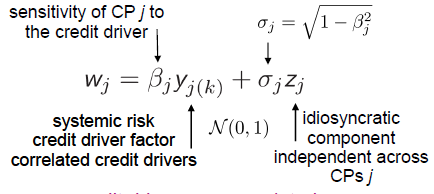




![alt text](https://)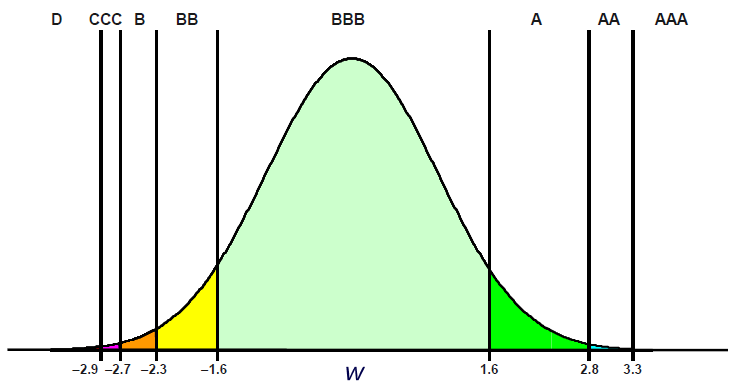

In [0]:
# Find credit-state for each counterparty
# 8 = AAA, 7 = AA, 6 = A, 5 = BBB, 4 = BB, 3 = B, 2 = CCC, 1 = default
CS = np.argmax(prob, axis=1) + 1
# Account for default recoveries
exposure[:, 0] = (1 - recov_rate) * exposure[:, 0]

# Compute credit-state boundaries
CS_Bdry = scipy.special.ndtri((np.cumsum(prob[:, 0:C - 1], 1)))

# Generating Scenarios
#Computing losses true distribution for out of sample data
Losses_out = np.zeros((Nout,K),dtype=np.ndarray)
for s in range(Nout):
  z = np.random.randn(1) #generating 1 random variable for Idiosynchratic scenario
  y = np.random.randn(50) #generating only 50 random variables with respect to credit drivers
  y1 = np.dot(sqrt_rho,y)  # computes y1 from the product of covariances and y
  w = np.zeros((K,1))      # assigning weights initially to zeros of (K,1) matrix
  for i in range(100):
    sigma=np.sqrt(1-np.power(beta[i],2))  # Sigma is computed usinng the mentioned formula with beta
    w[i]=(beta[i]*y1[int(driver[i])])+(sigma*z) # Corresponding weights are calculated from the above mentioned sigma and 𝑌𝑗(𝑘) values
    for j in [6,5,4,3,2,1,0]:      # for loop to check the asset states and used to compare weights with credit state boundaries
      if(w[i][0]>=CS_Bdry[i,j]):
        Losses_out[s,i]=exposure[i][j+1]  # Losses_out is assigned the value from exposure
        break

In [0]:
 # Normal approximation computed from out-of-sample scenarios
mu_l = np.mean(Losses_out, axis=0).reshape((K))
var_l = np.cov(Losses_out.astype(float).T) # Losses_out as a sparse matrix

# Compute portfolio weights
portf_v = sum(value)  # portfolio value
w0 = []
w0.append(value / portf_v)   # asset weights (portfolio 1)
w0.append(np.ones((K)) / K)  # asset weights (portfolio 2)
x0 = []
x0.append((portf_v / value) * w0[0])  # asset units (portfolio 1)
x0.append((portf_v / value) * w0[1])  # asset units (portfolio 2)

# Quantile levels (99%, 99.9%)
alphas = np.array([0.99, 0.999])
VaRout = np.zeros((2, alphas.size))
VaRinN = np.zeros((2, alphas.size))
CVaRout = np.zeros((2, alphas.size))
CVaRinN = np.zeros((2, alphas.size))

#Compute portfolio losses in outsampling scenarios
port_out=[]
port_out.append(np.dot(Losses_out,x0[0]))
port_out.append(np.dot(Losses_out,x0[1]))

### Computing VaR and CVaR for Out Sample Distribution

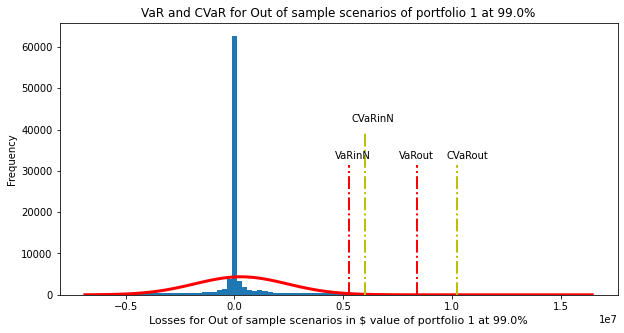

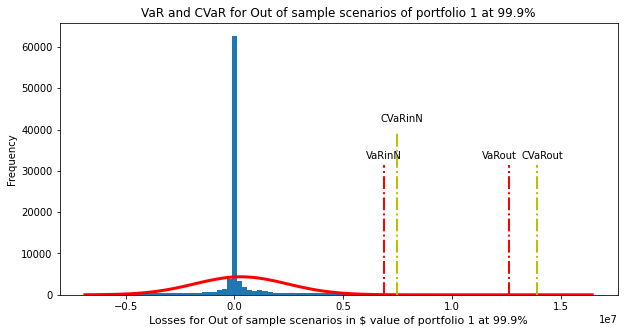

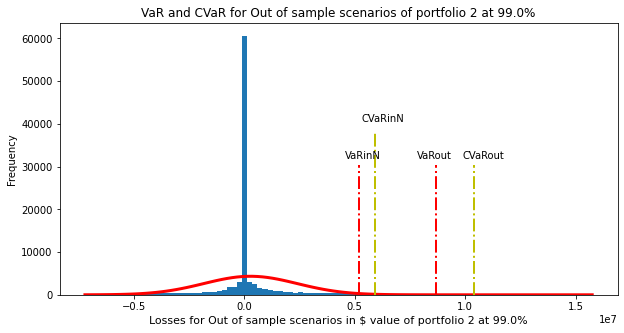

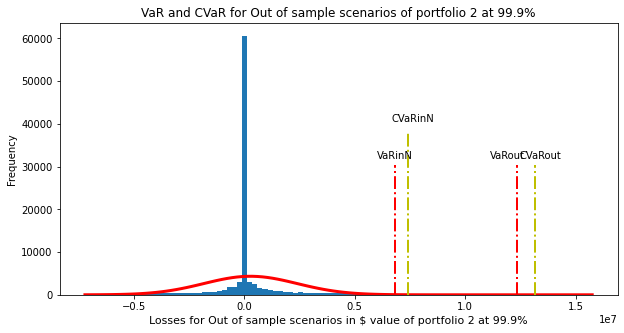

In [0]:
for portN in range(2):
    # Compute VaR and CVaR
    # Non-Normal distribution
    port_out[portN]=np.sort(port_out[portN],axis=0)

    #Normal Distribution  
    port_out_nmean=np.dot(mu_l.T,x0[portN])
    port_out_nstd=np.sqrt(np.dot(x0[portN].T,np.dot(var_l,x0[portN])))
    
    for q in range(len(alphas)): 
        alf = alphas[q]
        #Non-Normal Distribution
        VaRout[portN, q] = port_out[portN][int(math.ceil(Nout * alf)) - 1]
        CVaRout[portN, q] =(1 / (Nout * (1 - alf))) * ((math.ceil(Nout * alf) - Nout * alf) * VaRout[portN, q] + sum(port_out[portN][int(math.ceil(Nout * alf)):]))

        #Normal Distribution
        VaRinN[portN, q] = port_out_nmean + scs.norm.ppf(alf) * port_out_nstd
        CVaRinN[portN, q] = port_out_nmean + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 - alf)) * port_out_nstd

        #Plot of VaR and CvaR with respect to portfolio and alphas
        plt.figure(figsize = (10,5))
        frequencyCounts, binLocations, patches = plt.hist(port_out[portN], 100)
        normf = (1 / (port_out_nstd * math.sqrt(2 * math.pi)))*np.exp((-0.5*((binLocations - port_out_nmean) / port_out_nstd) ** 2).astype(float))
        normf = normf * sum(frequencyCounts) / sum(normf)
        plt.plot(binLocations, normf, color='r', linewidth=3.0)
        plt.plot([VaRinN[portN, q], VaRinN[portN, q]], [0, max(frequencyCounts) / 2], color='r', linewidth=2, linestyle='-.')
        plt.plot([VaRout[portN, q], VaRout[portN, q]], [0, max(frequencyCounts)/2], color='r', linewidth=2, linestyle='-.')
        plt.plot([CVaRinN[portN, q], CVaRinN[portN, q]], [0, max(frequencyCounts) / 1.6], color='y', linewidth=2, linestyle='-.')
        plt.plot([CVaRout[portN, q], CVaRout[portN, q]], [0, max(frequencyCounts)/2], color='y', linewidth=2, linestyle='-.')
        plt.text(0.9 * VaRout[portN, q], max(frequencyCounts) / 1.9, 'VaRout')
        plt.text(0.88 * VaRinN[portN, q], max(frequencyCounts) / 1.9, 'VaRinN')
        plt.text(0.95 * CVaRout[portN, q], max(frequencyCounts) / 1.9, 'CVaRout')
        plt.text(0.9 * CVaRinN[portN, q], max(frequencyCounts) / 1.5, 'CVaRinN')
        plt.title('VaR and CVaR for Out of sample scenarios of portfolio '+str(portN+1)+' at '+str(100*alf)+'%')
        plt.xlabel('Losses for Out of sample scenarios in $ value of portfolio '+str(portN+1)+' at '+str(100*alf)+'%', fontsize = 11)
        plt.ylabel('Frequency')
        plt.show()


In [0]:
# Perform 100 trials
N_trials = 100

VaRinMC1 = {}
VaRinMC2 = {}
VaRinN1 = {}
VaRinN2 = {}
CVaRinMC1 = {}
CVaRinMC2 = {}
CVaRinN1 = {}
CVaRinN2 = {}

In [0]:
for portN in range(2):
    for q in range(alphas.size):
        VaRinMC1[portN, q] = np.zeros(N_trials)
        VaRinMC2[portN, q] = np.zeros(N_trials)
        VaRinN1[portN, q] = np.zeros(N_trials)
        VaRinN2[portN, q] = np.zeros(N_trials)
        CVaRinMC1[portN, q] = np.zeros(N_trials)
        CVaRinMC2[portN, q] = np.zeros(N_trials)
        CVaRinN1[portN, q] = np.zeros(N_trials)
        CVaRinN2[portN, q] = np.zeros(N_trials)

### MonteCarlo Simulations

### Computing VaR and CVaR for Insample Distribution

In [0]:
Losses_inM1 = [] #Losses in MC1 with 100 trials
Losses_inM2 = [] #Losses in MC2 with 100 trials
portf_loss_inM1 = [] #Portfolio losses in MC1 with 100 trials
portf_loss_inM2 = [] #Portfolio losses in MC2 with 100 trials

In [0]:
for tr in range(1,N_trials+1):    # Multiple trials for better approximation fo the model
    # # Monte Carlo approximation 1 (MC1)
    Losses_inMC1 = np.zeros((Nin,K),dtype=np.ndarray)
    sc=0  # scenario counter
    for s in range(1000): # systemic scenarios
        y_MC1 = np.random.randn(50) #generating only 50 random variables
        y1_MC1 = np.dot(sqrt_rho,y_MC1)
        for si in range(Ns): # 5 idiosyncratic scenarios for each  systemic scenario
          z_MC1=np.random.randn(1)
          w_MC1=np.zeros((K,1))
          for i in range(100):
            sigma=np.sqrt(1-np.power(beta[i],2))
            w_MC1[i]=(beta[i]*y1_MC1[int(driver[i])])+(sigma*z_MC1)
            for j in [6,5,4,3,2,1,0]:      
              if(w_MC1[i][0]>=CS_Bdry[i,j]):
                Losses_inMC1[sc,i]=exposure[i][j+1]
                break
              
          sc+=1 # incrementing scenarios 
    # Calculate losses for MC1 approximation (5000 x 100)
    Losses_inM1.append(Losses_inMC1)

    # # Monte Carlo approximation 2
    Losses_inMC2 = np.zeros((Nin,K),dtype=np.ndarray)
    for s in range(Nin): # systemic scenarios (1 idiosyncratic scenario for each systemic)
      y_MC2 = np.random.randn(50) #generating only 50 random variables
      y1_MC2 = np.dot(sqrt_rho,y_MC2)
      z_MC2=np.random.randn(1)
      w_MC2=np.zeros((K,1))
      for i in range(K):
        sigma=np.sqrt(1-np.power(beta[i],2))
        w_MC2[i]=(beta[i]*y1_MC2[int(driver[i])])+(sigma*z_MC2)
        for j in [6,5,4,3,2,1,0]:      
          if(w_MC2[i][0]>=CS_Bdry[i,j]):
            Losses_inMC2[s,i]=exposure[i][j+1]
            break

    # Calculate losses for MC1 approximation (5000 x 100)
    Losses_inM2.append(Losses_inMC2)

    # Compute VaR and CVaR

    for portN in range(2):
        for q in range(alphas.size):
            alf = alphas[q]
            # Compute portfolio loss
            portf_loss_inMC1 = np.sort(np.dot(Losses_inMC1,x0[portN]),axis=0)
            portf_loss_inMC2 = np.sort(np.dot(Losses_inMC2,x0[portN]),axis=0)
            mu_MC1 = np.mean(Losses_inMC1, axis=0).reshape((K))
            var_MC1 = np.cov(Losses_inMC1.astype(float).T)
            mu_MC2 = np.mean(Losses_inMC2, axis=0).reshape((K))
            var_MC2 = np.cov(Losses_inMC2.astype(float).T)
            # Compute portfolio mean loss mu_p_MC1 and portfolio standard deviation of losses sigma_p_MC1
            # Compute portfolio mean loss mu_p_MC2 and portfolio standard deviation of losses sigma_p_MC2
            # Compute VaR and CVaR for the current trial
            mu_p_MC1 = np.dot(mu_MC1.T,x0[portN])
            sigma_p_MC1 = np.sqrt(np.dot(x0[portN].T,np.dot(var_MC1,x0[portN])))
            mu_p_MC2 = np.dot(mu_MC2.T,x0[portN])
            sigma_p_MC2 = np.sqrt(np.dot(x0[portN].T,np.dot(var_MC2,x0[portN])))
            VaRinN1[portN, q][tr - 1] = mu_p_MC1 + scs.norm.ppf(alf) * sigma_p_MC1
            VaRinN2[portN, q][tr - 1] = mu_p_MC2 + scs.norm.ppf(alf) * sigma_p_MC2
            VaRinMC1[portN, q][tr - 1] =  portf_loss_inMC1[int(math.ceil(Nin * alf)) - 1]
            VaRinMC2[portN, q][tr - 1] =  portf_loss_inMC2[int(math.ceil(Nin * alf)) - 1]
            CVaRinN1[portN, q][tr - 1] = mu_p_MC1 + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 - alf)) * sigma_p_MC1
            CVaRinN2[portN, q][tr - 1] = mu_p_MC2 + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 - alf)) * sigma_p_MC2
            CVaRinMC1[portN, q][tr - 1] =  (1 / (Nin * (1 - alf))) * ((math.ceil(Nin * alf) - Nin * alf) * VaRinN1[portN, q][tr - 1] + sum(portf_loss_inMC1[int(math.ceil(Nin * alf)):]))
            CVaRinMC2[portN, q][tr - 1] =  (1 / (Nin * (1 - alf))) * ((math.ceil(Nin * alf) - Nin * alf) * VaRinN2[portN, q][tr - 1] + sum(portf_loss_inMC2[int(math.ceil(Nin * alf)):]))
        portf_loss_inM1.append(portf_loss_inMC1)
        portf_loss_inM2.append(portf_loss_inMC2)

In [0]:
# Display VaR and CVaR
for portN in range(2):
    print('\nPortfolio {}:\n'.format(portN + 1))
    for q in range(alphas.size):
        alf = alphas[q]
        print('Out-of-sample: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRout[portN, q], 100 * alf, CVaRout[portN, q]))
        print('In-sample MC1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC1[portN, q]), 100 * alf, np.mean(CVaRinMC1[portN, q])))
        print('In-sample MC2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC2[portN, q]), 100 * alf, np.mean(CVaRinMC2[portN, q])))
        print('In-sample No: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRinN[portN, q], 100 * alf, CVaRinN[portN, q]))
        print('In-sample N1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinN1[portN, q]), 100 * alf, np.mean(CVaRinN1[portN, q])))
        print('In-sample N2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f\n' % (
        100 * alf, np.mean(VaRinN2[portN, q]), 100 * alf, np.mean(CVaRinN2[portN, q])))


Portfolio 1:

Out-of-sample: VaR 99.0% = $8375867.00, CVaR 99.0% = $10234614.32
In-sample MC1: VaR 99.0% = $8368356.07, CVaR 99.0% = $10112708.47
In-sample MC2: VaR 99.0% = $8358001.96, CVaR 99.0% = $10087716.50
In-sample No: VaR 99.0% = $5257358.37, CVaR 99.0% = $5979685.21
In-sample N1: VaR 99.0% = $5256046.79, CVaR 99.0% = $5978226.53
In-sample N2: VaR 99.0% = $5261584.66, CVaR 99.0% = $5983884.74

Out-of-sample: VaR 99.9% = $12615741.00, CVaR 99.9% = $13884173.70
In-sample MC1: VaR 99.9% = $12091303.94, CVaR 99.9% = $13346626.21
In-sample MC2: VaR 99.9% = $12036632.26, CVaR 99.9% = $13327962.20
In-sample No: VaR 99.9% = $6885652.94, CVaR 99.9% = $7475802.42
In-sample N1: VaR 99.9% = $6884009.75, CVaR 99.9% = $7474039.05
In-sample N2: VaR 99.9% = $6889818.90, CVaR 99.9% = $7479946.53


Portfolio 2:

Out-of-sample: VaR 99.0% = $8678786.06, CVaR 99.0% = $10384784.18
In-sample MC1: VaR 99.0% = $8691142.06, CVaR 99.0% = $10313656.69
In-sample MC2: VaR 99.0% = $8659467.37, CVaR 99.0% = 

In [0]:
portf_loss_MC1 = np.zeros((5000,2)) #Portfolio loss in MC1 for both the portfolios
portf_loss_MC2 = np.zeros((5000,2)) #Portfolio loss in MC2 for both the portfolios

In [0]:
for i in range(Nin):
    portf_loss1 = []
    portf_loss2 = []
    portf_loss3 = []
    portf_loss4 = []
    for tr in range(N_trials): 
        portf_loss1.append(portf_loss_inM1[2*tr][i]) #Portfolio loss in MC1 for portfolio 1
        portf_loss2.append(portf_loss_inM2[2*tr][i]) #Portfolio loss in MC2 for portfolio 1
        portf_loss3.append(portf_loss_inM1[2*tr+1][i]) #Portfolio loss in MC1 for portfolio 2
        portf_loss4.append(portf_loss_inM2[2*tr+1][i]) #Portfolio loss in MC2 for portfolio 2
    portf_loss_MC1[i,0] = np.mean(np.array(portf_loss1)) # Mean Portfolio loss across 100 trails in MC1 for portfolio 1
    portf_loss_MC2[i,0] = np.mean(np.array(portf_loss2)) # Mean Portfolio loss across 100 trails in MC2 for portfolio 1
    portf_loss_MC1[i,1] = np.mean(np.array(portf_loss3)) # Mean Portfolio loss across 100 trails in MC1 for portfolio 2
    portf_loss_MC2[i,1] = np.mean(np.array(portf_loss4)) # Mean Portfolio loss across 100 trails in MC2 for portfolio 2

In [0]:
for i in range(2):
    portf_loss_MC1[:,i] = np.sort(portf_loss_MC1[:,i]) #Sorting the mean portfolio loss in MC1 for both the portfolios
    portf_loss_MC2[:,i] = np.sort(portf_loss_MC2[:,i]) #Sorting the mean portfolio loss in MC2 for both the portfolios

In [0]:
VaRMC1 = np.zeros((2,2))
VaRMC2 = np.zeros((2,2))
VaRN1 = np.zeros((2,2))
VaRN2 = np.zeros((2,2))
CVaRMC1 = np.zeros((2,2))
CVaRMC2 = np.zeros((2,2))
CVaRN1 = np.zeros((2,2))
CVaRN2 = np.zeros((2,2))

for portN in range(2):
    for q in range(alphas.size):
        VaRMC1[portN, q] = np.mean(VaRinMC1[portN, q]) # Mean VaR across 100 trails in MC1 for all portfolios and alphas
        VaRMC2[portN, q] = np.mean(VaRinMC2[portN, q]) # Mean VaR across 100 trails in MC2 for all portfolios and alphas
        VaRN1[portN, q] = np.mean(VaRinN1[portN, q]) # Mean VaRN across 100 trails in MC1 for all portfolios and alphas
        VaRN2[portN, q] = np.mean(VaRinN2[portN, q]) # Mean VaRN across 100 trails in MC2 for all portfolios and alphas
        CVaRMC1[portN, q] = np.mean(CVaRinMC1[portN, q]) # Mean CVaR across 100 trails in MC1 for all portfolios and alphas
        CVaRMC2[portN, q] = np.mean(CVaRinMC2[portN, q]) # Mean CVaR across 100 trails in MC2 for all portfolios and alphas
        CVaRN1[portN, q] = np.mean(CVaRinN1[portN, q]) # Mean CVaRN across 100 trails in MC1 for all portfolios and alphas
        CVaRN2[portN, q] = np.mean(CVaRinN2[portN, q]) # Mean CVaRN across 100 trails in MC2 for all portfolios and alphas

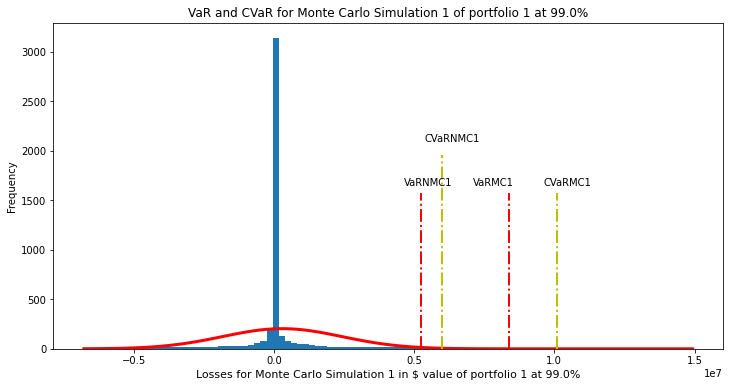

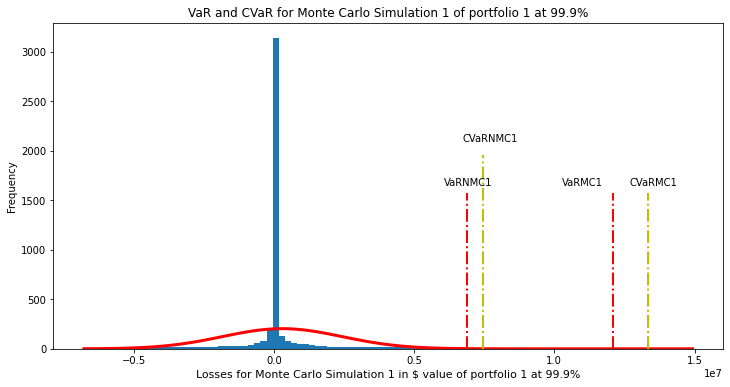

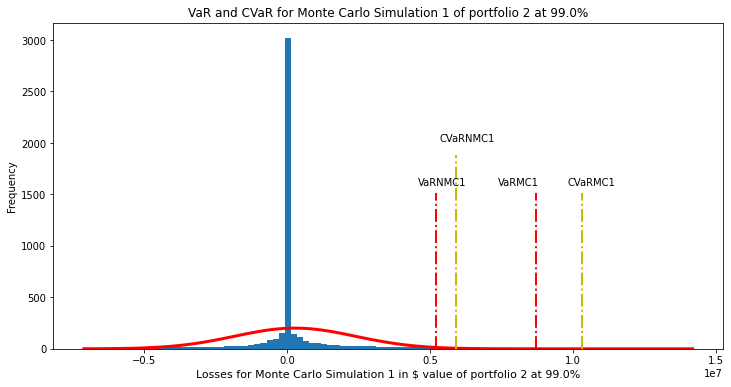

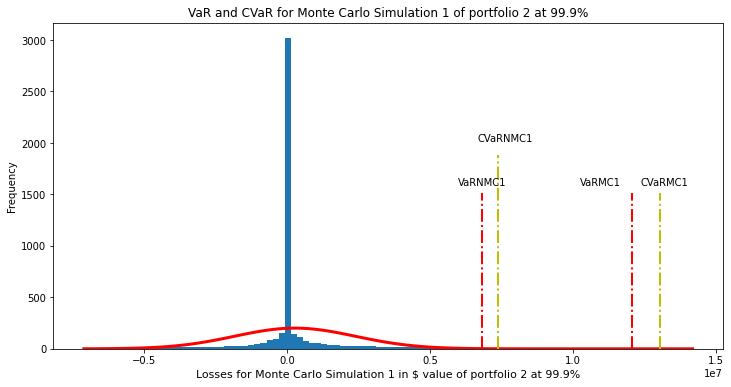

In [0]:
# #Plot of VaR and CvaR with respect to portfolio and alphas for MC1
for portN in range(2):
    
    for q in range(alphas.size):
        alf = alphas[q]
        
        plt.figure(figsize = (12,6))
        frequencyCounts, binLocations, patches = plt.hist(portf_loss_MC1[:,portN], 100)
        normf = (1 / (np.std(portf_loss_MC1[:,portN]) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(portf_loss_MC1[:,portN])) / np.std(portf_loss_MC1[:,portN])) ** 2)
        normf = normf * sum(frequencyCounts) / sum(normf)
        plt.plot(binLocations, normf, color='r', linewidth=3.0)
        plt.plot([VaRN1[portN, q], VaRN1[portN, q]], [0, max(frequencyCounts) / 2], color='r', linewidth=2, linestyle='-.')
        plt.plot([VaRMC1[portN, q], VaRMC1[portN, q]], [0, max(frequencyCounts)/2], color='r', linewidth=2, linestyle='-.')
        plt.plot([CVaRN1[portN, q], CVaRN1[portN, q]], [0, max(frequencyCounts) / 1.6], color='y', linewidth=2, linestyle='-.')
        plt.plot([CVaRMC1[portN, q], CVaRMC1[portN, q]], [0, max(frequencyCounts)/2], color='y', linewidth=2, linestyle='-.')
        plt.text(0.85 * VaRMC1[portN, q], max(frequencyCounts) / 1.9, 'VaRMC1')
        plt.text(0.88 * VaRN1[portN, q], max(frequencyCounts) / 1.9, 'VaRNMC1')
        plt.text(0.95 * CVaRMC1[portN, q], max(frequencyCounts) / 1.9, 'CVaRMC1')
        plt.text(0.9 * CVaRN1[portN, q], max(frequencyCounts) / 1.5, 'CVaRNMC1')
        plt.title('VaR and CVaR for Monte Carlo Simulation 1 of portfolio '+str(portN+1)+' at '+str(100*alf)+'%')
        plt.xlabel('Losses for Monte Carlo Simulation 1 in $ value of portfolio '+str(portN+1)+' at '+str(100*alf)+'%', fontsize = 11)
        plt.ylabel('Frequency')
        plt.show()

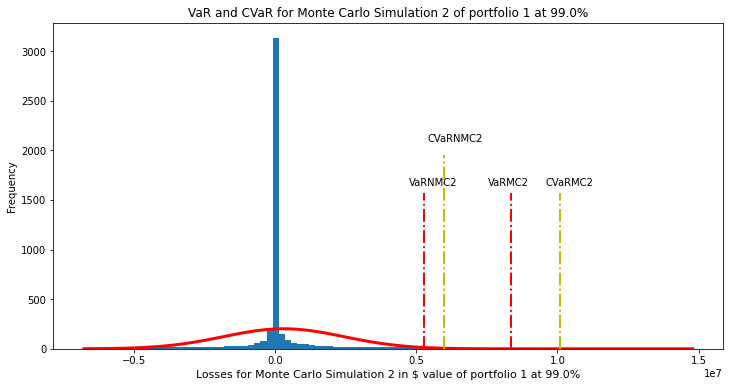

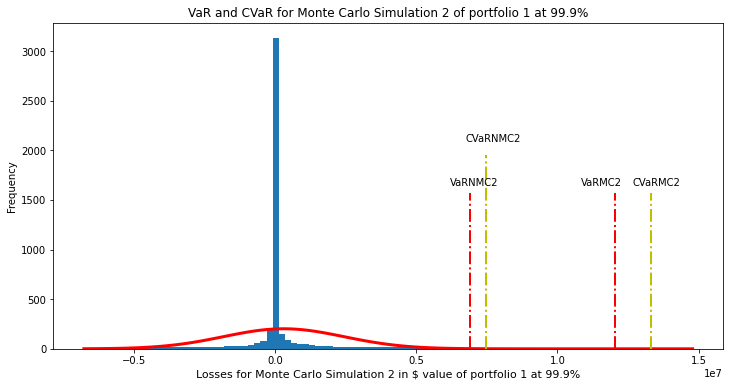

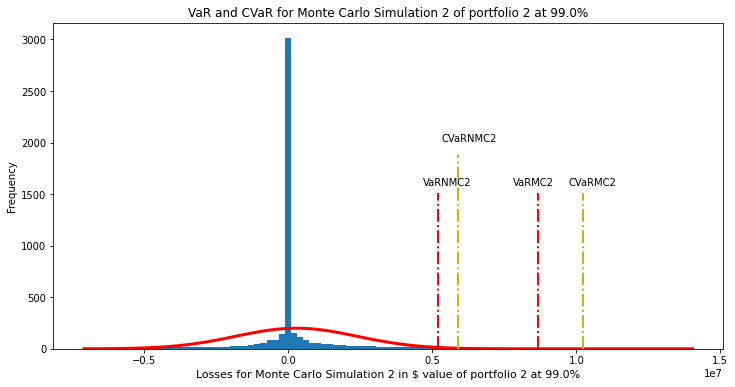

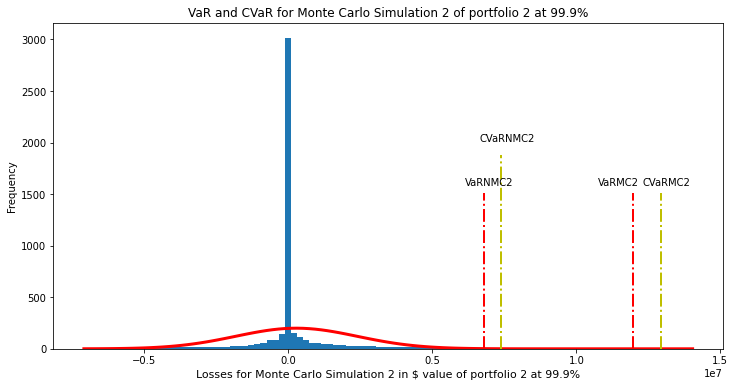

In [0]:
# #Plot of VaR and CvaR with respect to portfolio and alphas for MC2
for portN in range(2):
    
    for q in range(alphas.size):
        alf = alphas[q]
        
        plt.figure(figsize = (12,6))
        frequencyCounts, binLocations, patches = plt.hist(portf_loss_MC2[:,portN], 100)
        normf = (1 / (np.std(portf_loss_MC2[:,portN]) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(portf_loss_MC2[:,portN])) / np.std(portf_loss_MC2[:,portN])) ** 2)
        normf = normf * sum(frequencyCounts) / sum(normf)
        plt.plot(binLocations, normf, color='r', linewidth=3.0)
        plt.plot([VaRN2[portN, q], VaRN2[portN, q]], [0, max(frequencyCounts) / 2], color='r', linewidth=2, linestyle='-.')
        plt.plot([VaRMC2[portN, q], VaRMC2[portN, q]], [0, max(frequencyCounts)/2], color='r', linewidth=2, linestyle='-.')
        plt.plot([CVaRN2[portN, q], CVaRN2[portN, q]], [0, max(frequencyCounts) / 1.6], color='y', linewidth=2, linestyle='-.')
        plt.plot([CVaRMC2[portN, q], CVaRMC2[portN, q]], [0, max(frequencyCounts)/2], color='y', linewidth=2, linestyle='-.')
        plt.text(0.9 * VaRMC2[portN, q], max(frequencyCounts) / 1.9, 'VaRMC2')
        plt.text(0.9 * VaRN2[portN, q], max(frequencyCounts) / 1.9, 'VaRNMC2')
        plt.text(0.95 * CVaRMC2[portN, q], max(frequencyCounts) / 1.9, 'CVaRMC2')
        plt.text(0.9 * CVaRN2[portN, q], max(frequencyCounts) / 1.5, 'CVaRNMC2')
        plt.title('VaR and CVaR for Monte Carlo Simulation 2 of portfolio '+str(portN+1)+' at '+str(100*alf)+'%')
        plt.xlabel('Losses for Monte Carlo Simulation 2 in $ value of portfolio '+str(portN+1)+' at '+str(100*alf)+'%', fontsize = 11)
        plt.ylabel('Frequency')
        plt.show()

### Mean and Standard deviation

In [0]:
# Displaying means and standard deviation
for portN in range(2):
    print('\nPortfolio {}:\n'.format(portN + 1))
    for q in range(alphas.size):
        alf = alphas[q]
        print('Mean MC1: VaR %4.1f%% = $%6.2f'%(100 * alf, np.mean(mu_p_MC1)))
        print('Mean MC2: VaR %4.1f%% = $%6.2f'%(100 * alf, np.mean(mu_p_MC2)))
        print('Standard Deviation MC1: VaR %4.1f%% = $%6.2f'%(100 * alf, np.mean(sigma_p_MC1)))
        print('Standard Deviation MC2: VaR %4.1f%% = $%6.2f'%(100 * alf, np.mean(sigma_p_MC2)))


Portfolio 1:

Mean MC1: VaR 99.0% = $292596.31
Mean MC2: VaR 99.0% = $313037.27
Standard Deviation MC1: VaR 99.0% = $2138272.94
Standard Deviation MC2: VaR 99.0% = $2165145.32
Mean MC1: VaR 99.9% = $292596.31
Mean MC2: VaR 99.9% = $313037.27
Standard Deviation MC1: VaR 99.9% = $2138272.94
Standard Deviation MC2: VaR 99.9% = $2165145.32

Portfolio 2:

Mean MC1: VaR 99.0% = $292596.31
Mean MC2: VaR 99.0% = $313037.27
Standard Deviation MC1: VaR 99.0% = $2138272.94
Standard Deviation MC2: VaR 99.0% = $2165145.32
Mean MC1: VaR 99.9% = $292596.31
Mean MC2: VaR 99.9% = $313037.27
Standard Deviation MC1: VaR 99.9% = $2138272.94
Standard Deviation MC2: VaR 99.9% = $2165145.32


### Sampling Error

Comparing non-Normal approximations to the true (out-of-
sample) loss distribution.

In [0]:
# Display Sampling Error

sev1 = np.zeros((2,2))
sev2 = np.zeros((2,2))
secv1 = np.zeros((2,2))
secv2 = np.zeros((2,2))
for portN in range(2):
    print('\nPortfolio {}:\n'.format(portN + 1))
    for q in range(alphas.size):
        alf = alphas[q]
        sev1[portN, q] = np.abs((VaRout[portN, q]-np.mean(VaRinMC1[portN, q]))/VaRout[portN, q])*100 #Sampling error in MC1 VaR
        sev2[portN, q] = np.abs((VaRout[portN, q]-np.mean(VaRinMC2[portN, q]))/VaRout[portN, q])*100 #Sampling error in MC2 VaR
        secv1[portN, q] = np.abs((CVaRout[portN, q]-np.mean(CVaRinMC1[portN, q]))/CVaRout[portN, q])*100 #Sampling error in MC1 CVaR
        secv2[portN, q] = np.abs((CVaRout[portN, q]-np.mean(CVaRinMC2[portN, q]))/CVaRout[portN, q])*100 #Sampling error in MC2 CVaR
        print('Out-of-sample: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRout[portN, q], 100 * alf, CVaRout[portN, q]))
        print('In-sample MC1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC1[portN, q]), 100 * alf, np.mean(CVaRinMC1[portN, q])))
        print('In-sample MC2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC2[portN, q]), 100 * alf, np.mean(CVaRinMC2[portN, q])))
        print('Sampling Error MC1: VaR %4.1f%% = %4.4f%%, CVaR %4.1f%% = %4.4f%%' % (
        100 * alf, sev1[portN, q], 100 * alf, secv1[portN, q]))
        print('Sampling Error MC2: VaR %4.1f%% = %4.4f%%, CVaR %4.1f%% = %4.4f%%\n' % (
        100 * alf, sev2[portN, q], 100 * alf, secv2[portN, q]))


Portfolio 1:

Out-of-sample: VaR 99.0% = $8375867.00, CVaR 99.0% = $10234614.32
In-sample MC1: VaR 99.0% = $8368356.07, CVaR 99.0% = $10112708.47
In-sample MC2: VaR 99.0% = $8358001.96, CVaR 99.0% = $10087716.50
Sampling Error MC1: VaR 99.0% = 0.0897%, CVaR 99.0% = 1.1911%
Sampling Error MC2: VaR 99.0% = 0.2133%, CVaR 99.0% = 1.4353%

Out-of-sample: VaR 99.9% = $12615741.00, CVaR 99.9% = $13884173.70
In-sample MC1: VaR 99.9% = $12091303.94, CVaR 99.9% = $13346626.21
In-sample MC2: VaR 99.9% = $12036632.26, CVaR 99.9% = $13327962.20
Sampling Error MC1: VaR 99.9% = 4.1570%, CVaR 99.9% = 3.8717%
Sampling Error MC2: VaR 99.9% = 4.5904%, CVaR 99.9% = 4.0061%


Portfolio 2:

Out-of-sample: VaR 99.0% = $8678786.06, CVaR 99.0% = $10384784.18
In-sample MC1: VaR 99.0% = $8691142.06, CVaR 99.0% = $10313656.69
In-sample MC2: VaR 99.0% = $8659467.37, CVaR 99.0% = $10246117.06
Sampling Error MC1: VaR 99.0% = 0.1424%, CVaR 99.0% = 0.6849%
Sampling Error MC2: VaR 99.0% = 0.2226%, CVaR 99.0% = 1.3353%

### Modeling Error

Comparing Normal approximations
to the true (out-of-sample) loss distribution.

In [0]:
# Display Model Error

mev = np.zeros((2,2))
mev1= np.zeros((2,2))
mev2= np.zeros((2,2))
mecv = np.zeros((2,2))
mecv1 = np.zeros((2,2))
mecv2 = np.zeros((2,2))


for portN in range(2):
    print('\nPortfolio {}:\n'.format(portN + 1))
    for q in range(alphas.size):
        alf = alphas[q]
        mev[portN, q] = np.abs((VaRout[portN, q]-VaRinN[portN, q])/VaRout[portN, q])*100 #Model error VaR
        mecv[portN, q] = np.abs((CVaRout[portN, q]-CVaRinN[portN, q])/CVaRout[portN, q])*100 #Model error CVaR
        mev1[portN, q] = np.abs((VaRout[portN, q]-np.mean(VaRinN1[portN, q]))/VaRout[portN, q])*100 #Model error VaR
        mecv1[portN, q] = np.abs((CVaRout[portN, q]-np.mean(CVaRinN1[portN, q]))/CVaRout[portN, q])*100 #Model error CVaR
        mev2[portN, q] = np.abs((VaRout[portN, q]-np.mean(VaRinN2[portN, q]))/VaRout[portN, q])*100 #Model error VaR
        mecv2[portN, q] = np.abs((CVaRout[portN, q]-np.mean(CVaRinN2[portN, q]))/CVaRout[portN, q])*100 #Model error CVaR
        print('Out-of-sample: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRout[portN, q], 100 * alf, CVaRout[portN, q]))
        print('In-sample No: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRinN[portN, q], 100 * alf, CVaRinN[portN, q]))
        print('Model Error: VaR %4.1f%% = %4.4f%%, CVaR %4.1f%% = %4.4f%%\n' % (
        100 * alf, mev[portN, q], 100 * alf, mecv[portN, q]))
        print('In-sample N1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinN1[portN, q]), 100 * alf, np.mean(CVaRinN1[portN, q])))
        print('Model Error: VaR %4.1f%% = %4.4f%%, CVaR %4.1f%% = %4.4f%%\n' % (
        100 * alf, mev1[portN, q], 100 * alf, mecv1[portN, q]))
        print('In-sample N2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinN2[portN, q]), 100 * alf, np.mean(CVaRinN2[portN, q])))
        print('Model Error: VaR %4.1f%% = %4.4f%%, CVaR %4.1f%% = %4.4f%%\n' % (
        100 * alf, mev2[portN, q], 100 * alf, mecv2[portN, q]))



Portfolio 1:

Out-of-sample: VaR 99.0% = $8375867.00, CVaR 99.0% = $10234614.32
In-sample No: VaR 99.0% = $5257358.37, CVaR 99.0% = $5979685.21
Model Error: VaR 99.0% = 37.2321%, CVaR 99.0% = 41.5739%

In-sample N1: VaR 99.0% = $5256046.79, CVaR 99.0% = $5978226.53
Model Error: VaR 99.0% = 37.2477%, CVaR 99.0% = 41.5882%

In-sample N2: VaR 99.0% = $5261584.66, CVaR 99.0% = $5983884.74
Model Error: VaR 99.0% = 37.1816%, CVaR 99.0% = 41.5329%

Out-of-sample: VaR 99.9% = $12615741.00, CVaR 99.9% = $13884173.70
In-sample No: VaR 99.9% = $6885652.94, CVaR 99.9% = $7475802.42
Model Error: VaR 99.9% = 45.4201%, CVaR 99.9% = 46.1559%

In-sample N1: VaR 99.9% = $6884009.75, CVaR 99.9% = $7474039.05
Model Error: VaR 99.9% = 45.4332%, CVaR 99.9% = 46.1686%

In-sample N2: VaR 99.9% = $6889818.90, CVaR 99.9% = $7479946.53
Model Error: VaR 99.9% = 45.3871%, CVaR 99.9% = 46.1261%


Portfolio 2:

Out-of-sample: VaR 99.0% = $8678786.06, CVaR 99.0% = $10384784.18
In-sample No: VaR 99.0% = $5192426.86, 